# Latitude Banded SIF Hovmoller Plot
---

In [1]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [6]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew

def aggregate_lat(ds):
    # Map to 1-degree latitude bins
    lat_bins = np.arange(-85, 90, 5)
    lat_centers = np.arange(-82.5, 87.5, 5)
    
    df = ds.to_dataframe()
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lat"]).mean().to_xarray()

In [7]:
# Open multiple datasets across yearly subdirectories
paths = "../data/OCO2_L2_Lite_SIF_10r/*/*.nc4"

DS = xarray.open_mfdataset(paths, preprocess=prep_sif, parallel=True)

In [44]:
# Compute monthly averages over 1-degree bands
DS_grid = DS.resample(time="1MS").map(aggregate_lat)

In [ ]:
## Maybe attempt seaborn heatmap / facet combo (otherwise loop subplots)

In [31]:
years = DS_grid.groupby("time.year")
years.groups

{2014: [0, 1, 2, 3],
 2015: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 2016: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
 2017: [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 2018: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
 2019: [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
 2020: [64, 65, 66, 67, 68, 69, 70]}

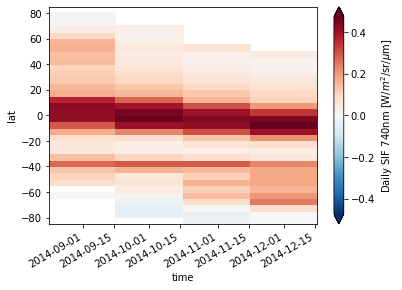

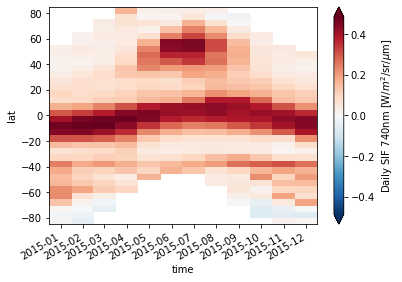

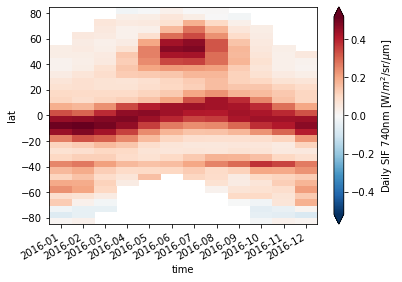

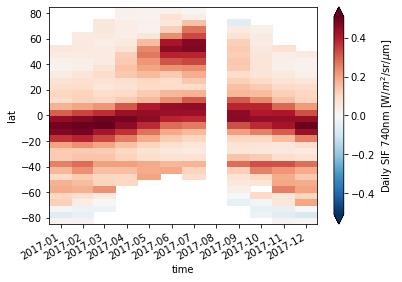

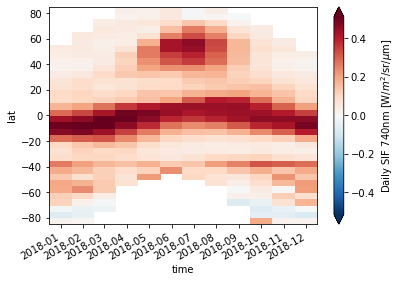

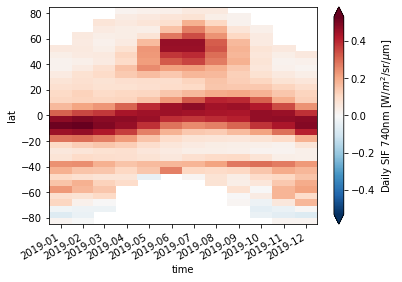

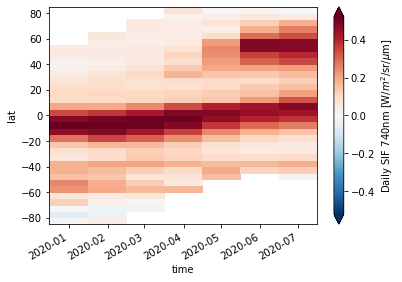

In [67]:
for y in years.groups:
    da = DS_grid.isel(time=np.array(years.groups[y])).sif.T
    plt.figure()
    xarray.plot.pcolormesh(da, extend="both",
                          cbar_kwargs={"label": "Daily SIF 740nm [W/$m^2$/sr/$\mu$m]"}
                          )